In [345]:
### Packages for array processing and DataFrame representation
import numpy as np
import pandas as pd

### For storing panel data
from time_matrix.structuring_and_exploration import panelDataSet

### Plotting utilities
import matplotlib.pyplot as plt

import seaborn as sns

### Matrix completion models
from time_matrix.matrix_completion import validation, LAPIS, softImpute, r1Comp

from numpy.linalg import matrix_rank

### Treatment effect estimation utility
import time_matrix.estimation_and_inference as ef

import re

In [346]:
def timeConverter(monthCommaYear, endTime):
    ### Converts Month, year variable to adoption duration variable  
    
    ### endTime corresponds to the first time point NOT in the 
    ### observation period. 
    
    timeDict = {'Jan':0, 'Feb':1, 'Mar': 2, 'Apr': 3, 'May': 4, 'Jun': 5,
               'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11}
    try:
    
        theMonth = re.search(r'^.*(?=,)', monthCommaYear)[0]
        
        theYear = re.search('[0-9]+', monthCommaYear)[0]
        
        realTime = 12*(endTime-int(theYear)) - timeDict[theMonth]
        
        return(realTime)
        
    except: 
        
        return(0)
    
    
    
    

In [347]:
### Simulated unemployment data, along with when counties adoped a job retraining program
unemploymentData = pd.read_csv('./Unemployment and Job Retraining/unemployment_data.csv')
programAdoptionData = pd.read_csv('./Unemployment and Job Retraining/retraining_program_adoption_data.csv')

### Location data for US counties 
geoData = pd.read_csv('./Unemployment and Job Retraining/geo_data.csv')

In [277]:
programAdoptionData['Program Duration'] = programAdoptionData['Implementation Date']\
.apply(lambda x: timeConverter(x, 2020))

In [278]:
unempPanelData = panelDataSet(unemploymentData, 'region_code', 'time', 
                              'seasonally adjusted unemployment')

In [279]:
unempPanelDataWide = unempPanelData.getWideFormat()

### Find entries that are unknown, as some data was missing 
### due to preprocessing imperfections
DMissing = pd.isnull(unempPanelDataWide)*1

### Replace unknown values with 0
unempPanelDataWide.fillna(0, inplace=True)

In [280]:
untreatedUnempPanelData = panelDataSet(actualUnemploymentData, 'region_code', 'time', 
                              'seasonal_adjust_unemp')

### Getting wide format for the unemployment data
untreatedUnempPanelDataWide = untreatedUnempPanelData.getWideFormat()

In [281]:
durationsSeries = programAdoptionData[['region_code', 'Program Duration']]
durationsSeries.set_index('region_code', inplace=True)

In [282]:
### Create the treated component of the missingness matrix
DTreated = np.zeros(unempPanelDataWide.shape)

DTreated = pd.DataFrame(DTreated, index = unempPanelDataWide.index,
                columns = unempPanelDataWide.columns)

for code in durationsSeries.index:
    
    DTreated.loc[code, :] = np.concatenate((np.zeros(DTreated.shape[1]-durationsSeries.loc[code]),
                                    np.ones(durationsSeries.loc[code])))
    
### The complete missingness matrix, where cells cannot be both treated and missing
D = DMissing+DTreated

In [283]:
### Verifies the matrices are ordered correctly
any(unempPanelDataWide.index != D.index)

False

In [284]:
### Using a softImpute model to estimate the unobserved untreated potential outcomes

### Finding best penalty parameter
validationSoftImpute = validation(unempPanelDataWide.values, D.values, 
                                  r1Comp, np.linspace(0, 100, 10), r_init=40)

bestLambda = validationSoftImpute.idxmin()

### Building best model
r1CompMod = r1Comp(bestLambda)

r1CompMatrix = r1CompMod.fit(unempPanelDataWide.values, D.values)

r1CompMatrix = pd.DataFrame(r1CompMatrix, 
                                index = unempPanelDataWide.index,
                                columns = unempPanelDataWide.columns)

In [286]:
effectDataFrame = ef.makeTreatmentDataFrame(unempPanelDataWide, r1CompMatrix,
                         DTreated)

In [287]:
effect = effectDataFrame.groupby([ 'time_since_intervention_adoption'])\
['estimated_effect'].apply(lambda x: x.mean())

In [288]:
effectDataFrame = geoData.merge(effectDataFrame)

In [341]:
### The effect of job retraining on unemployment, 
### where counties are aggregated into the region of the US they are in. 
effectByState = effectDataFrame.groupby(['region', 'time_since_intervention_adoption'])\
['estimated_effect'].apply(lambda x: x.mean())
effectByState = pd.DataFrame(effectByState).reset_index()

effectByState = effectByState.rename({'region':'Region'}, axis=1)

Text(0.5, 1.0, 'Change in Unemployment, by Region')

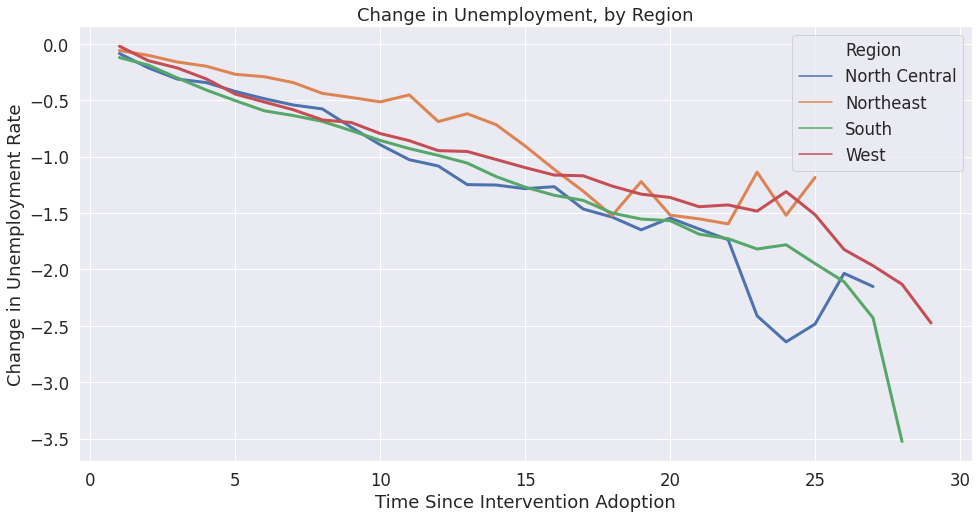

In [344]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale=1.5)

g = sns.lineplot(data=effectByState, x='time_since_intervention_adoption', y='estimated_effect', 
             hue='Region', linewidth=3)

plt.xlabel('Time Since Intervention Adoption')
plt.ylabel('Change in Unemployment Rate')
plt.title('Change in Unemployment, by Region')
